# Liverpool Crime Mapping

To get a sense of the data analysis paths available, we first perform exploratory data analysis. Below is a simple map and graph based interaction between crimes in Merseyside and their coordinates.


Github repository doesn't render interactive features of Jupyter notebooks like folium maps, so as a workaround please put the github link of this notebook into [nbviewer](https://nbviewer.org) and all the maps will be rendered as normal to explore!


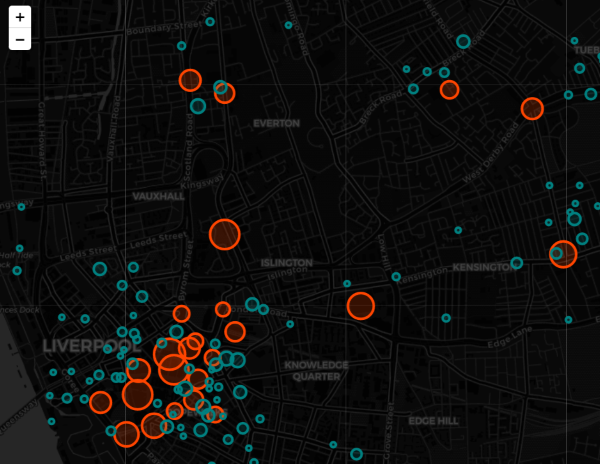

In [1]:
import pandas as pd
import glob
import os

#(1) combine 12 months of crime data 07/2020 - 07/2021
path = r'C:\Users\pigle\OneDrive\Documents\Business Analytics\MSc Project\Raw_Data_covidYear' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))  ## use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
df   = pd.concat(df_from_each_file, ignore_index=True) ## doesn't create a list, nor does it append to one
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Last outcome category
0,NaN,2020-07,Merseyside Police,Merseyside Police,-2.747770,53.389499,On or near Cronton Road,E01012393,Halton 001B,Anti-social behaviour,NaN,NaN,NaN
1,NaN,2020-07,Merseyside Police,Merseyside Police,-2.747770,53.389499,On or near Cronton Road,E01012393,Halton 001B,Anti-social behaviour,NaN,NaN,NaN
2,NaN,2020-07,Merseyside Police,Merseyside Police,-2.773523,53.371033,On or near Acrefield Road,E01012390,Halton 004B,Anti-social behaviour,NaN,NaN,NaN
3,84fd2e6085a0f18c3f4744af4cc9cb7dc5f137d1419285...,2020-07,Merseyside Police,Merseyside Police,-2.781128,53.367730,On or near Dale Close,E01012389,Halton 008A,Public order,Investigation complete; no suspect identified,NaN,NaN
4,1b237bdc76fe413e91094d0dfc4f0be5e7fe9fcb51e3c7...,2020-07,Merseyside Police,Merseyside Police,-2.869972,53.488240,On or near Roman Way,E01006448,Knowsley 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,NaN


In [2]:
import folium 
import matplotlib.pyplot as plt
import seaborn as sns 

## Check for null values in the raw dataset

<AxesSubplot:>

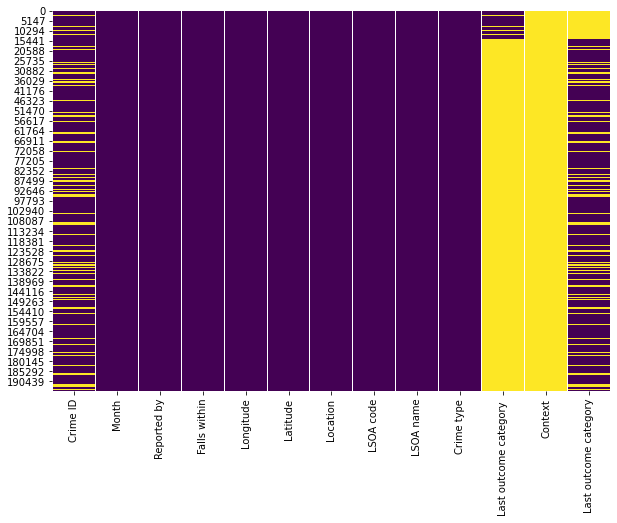

In [3]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cbar= False, cmap = 'viridis')

In [4]:
df = df.drop(columns= ['Crime ID', 'Reported by', 'Falls within', 'LSOA code',
                       'Context',], axis=1)

# Minor self-explanatory data exploration 
Focusing on top 10 values counts for crime type and location descriptors

In [5]:
pd.value_counts(df['Crime type'])[:10]


Violence and sexual offences    65688
Anti-social behaviour           42852
Public order                    19832
Criminal damage and arson       15587
Drugs                           13579
Burglary                         7970
Other theft                      7800
Vehicle crime                    6798
Shoplifting                      6450
Other crime                      3489
Name: Crime type, dtype: int64

In [6]:
pd.value_counts(df['Location'])[:10]


On or near Parking Area                           5362
On or near Supermarket                            4856
On or near Shopping Area                          3039
On or near Sports/Recreation Area                 2704
On or near Petrol Station                         2370
On or near Hospital                               1216
On or near Nightclub                              1002
On or near Police Station                          812
On or near Pedestrian Subway                       722
On or near Further/Higher Educational Building     664
Name: Location, dtype: int64

# Locations descriptors and semantics

<AxesSubplot:xlabel='count', ylabel='Location'>

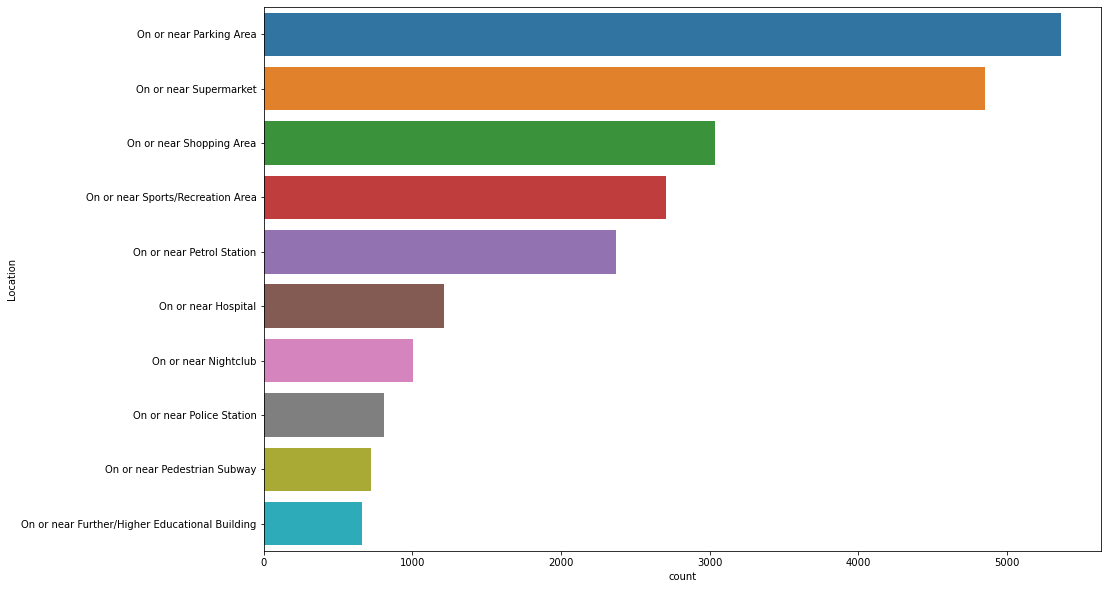

In [7]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location', data= df, order= df['Location'].value_counts().iloc[:10].index)

In [8]:
locations = df.groupby('LSOA name').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude', 'Location']]
new_locations.head()

,Latitude,Longitude,Location
LSOA name,,,
Cheshire West and Chester 001D,53.314304,-3.069158,On or near Chester High Road
Cheshire West and Chester 004C,53.301004,-2.957604,On or near New Chester Road
Cheshire West and Chester 004D,53.294928,-3.020408,On or near Lydiate Lane
Halton 001A,53.389082,-2.714487,On or near Mill Lane
Halton 001B,53.389499,-2.747770,On or near Cronton Road


# Preparing the first map 
Using one crime for each of the smallest division sub-district locations e.g. Liverpool 021A. This maps every single community area in Merseyside where an offence has occured.  

In [9]:
liverpool_map = folium.Map(location=[53.400002, -2.983333],
                           zoom_start=11,
                           tiles="CartoDB dark_matter")


In [10]:
for i in range(len(new_locations)):
    lat = new_locations.iloc[i][0]
    long = new_locations.iloc[i][1]
    popup_text= """LSOA area : {}<br>
                Location : {}<br>"""
    popup_text = popup_text.format(new_locations.index[i],
                new_locations.iloc[i][2]
                )
    
    folium.CircleMarker(location= [lat,long], popup= popup_text, 
                        fill= True).add_to(liverpool_map)
liverpool_map

# Simple criminal rate index

In [11]:
df['unique_locations'] = list(zip(df['Longitude'], df['Latitude']))
unique_locations = df['unique_locations'].value_counts()

In [12]:
CR_index = pd.DataFrame({"Raw_String" : unique_locations.index, 
                         "ValueCount": unique_locations})
CR_index.index= range(len(unique_locations))
print(CR_index.head())
temp_index_list = list(CR_index['Raw_String'])

               Raw_String  ValueCount
0  (-2.983878, 53.406618)         327
1  (-2.983495, 53.405686)         307
2   (-2.978384, 53.41371)         306
3  (-2.987117, 53.404218)         298
4  (-2.964809, 53.409497)         274


In [13]:
def Location_extractor1(temp_index):
    longitude = []
    latitude = []
    for i in temp_index:
        longitude.append(i[0])
        latitude.append(i[1])
    return longitude, latitude

In [14]:
CR_index['LocationCoord_lat'],CR_index['LocationCoord_long'] = Location_extractor1(temp_index_list)
CR_index = CR_index.drop(columns=['Raw_String'], axis = 1)
print(CR_index)

       ValueCount  LocationCoord_lat  LocationCoord_long
0             327          -2.983878           53.406618
1             307          -2.983495           53.405686
2             306          -2.978384           53.413710
3             298          -2.987117           53.404218
4             274          -2.964809           53.409497
...           ...                ...                 ...
16800           1          -2.892652           53.493178
16801           1          -2.915605           53.361363
16802           1          -3.090868           53.352176
16803           1          -3.062999           53.551101
16804           1          -2.998245           53.496567

[16805 rows x 3 columns]


In [15]:
%%time

liverpool_map_CR = folium.Map(location=[53.400002, -2.983333],
                           zoom_start=11,
                           tiles="CartoDB dark_matter")

for i in range(500):
    lat = CR_index['LocationCoord_lat'].iloc[i]
    long = CR_index['LocationCoord_long'].iloc[i]
    radius = CR_index['ValueCount'].iloc[i] / 18
    if CR_index['ValueCount'].iloc[i] > 150:
        color = "#FF4500"
    else:
        color = "#008080"
        
    popup_text = """ Latitude: {}<br>
                Longitude: {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(long, lat, CR_index['ValueCount'].iloc[i])
    
    folium.CircleMarker(location = [long, lat], popup= popup_text,radius = radius, 
                        color = color, fill = True).add_to(liverpool_map_CR)

liverpool_map_CR

Wall time: 211 ms


In [16]:
#os.chdir(r'C:\Users\pigle\OneDrive\Documents\Business Analytics\MSc Project')
#liverpool_map.save("mymap1.html") ##saves maps in cwd as html   

# A closer look at violent crime

<AxesSubplot:xlabel='count', ylabel='Last outcome category'>

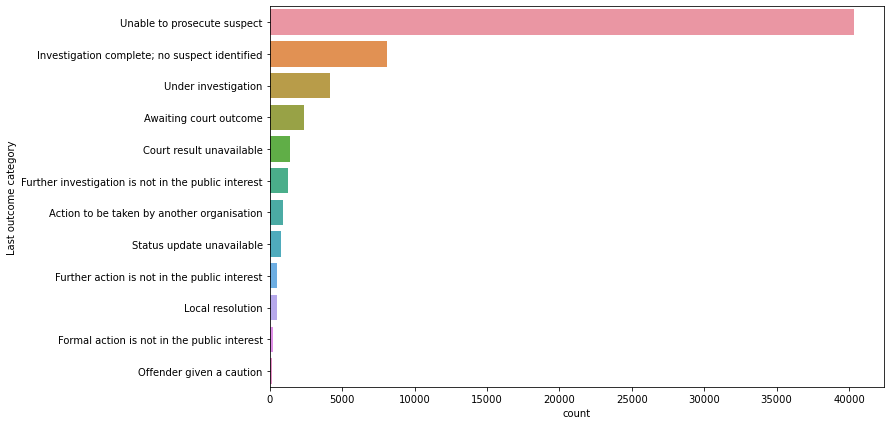

In [17]:
df_crimetype_violence = df[df['Crime type']=='Violence and sexual offences']
plt.figure(figsize = (11, 7))
sns.countplot(y = df_crimetype_violence['Last outcome category'], 
              order=df_crimetype_violence['Last outcome category'].value_counts().index)

# Alternative count method for sorted array count 

<AxesSubplot:xlabel='Counts', ylabel='Last outcome category'>

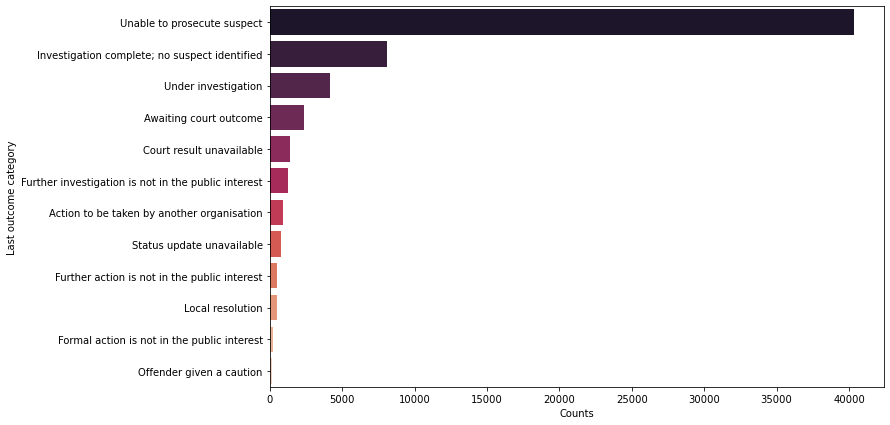

In [18]:
df_crimetype_violence_data=pd.DataFrame({"Counts": 
                                         df_crimetype_violence
                                         ['Last outcome category'].value_counts(),
                                         "Last outcome category":
                                             df_crimetype_violence
                                             ['Last outcome category'].value_counts().index})
df_crimetype_violence_data.reset_index(inplace=True)
df_crimetype_violence_data = df_crimetype_violence_data.drop(columns=['index'],
                                                             axis = 1)
df_crimetype_violence_data.head()   

plt.figure(figsize = (11, 7))
sns.barplot(y="Last outcome category", x = "Counts", data = df_crimetype_violence_data, 
            palette="rocket")

# Violent crime and location

<AxesSubplot:xlabel='Violent Crime Count', ylabel='Location'>

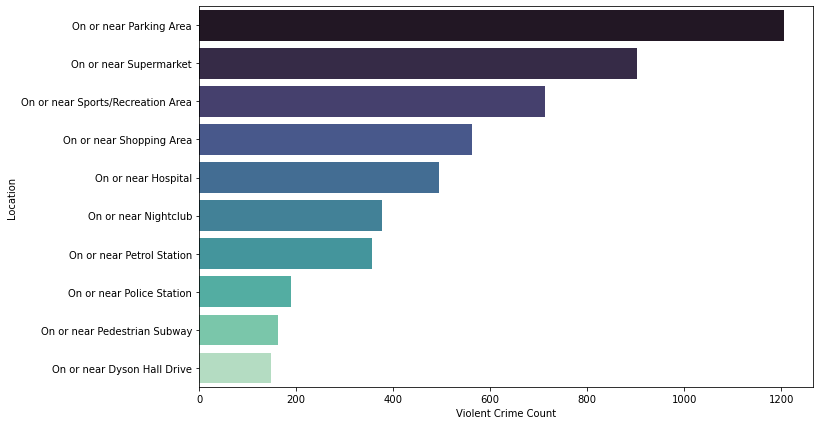

In [19]:
df_crimetype_violence_data2=pd.DataFrame({"Violent Crime Count": 
                                         df_crimetype_violence
                                         ['Location'].value_counts(),
                                         "Location":
                                             df_crimetype_violence
                                             ['Location'].value_counts().index})

df_crimetype_violence_data3 = df_crimetype_violence_data2[:10]    
plt.figure(figsize = (11, 7))
sns.barplot(y="Location", x = "Violent Crime Count", data = df_crimetype_violence_data3, 
            palette="mako")

# Monthly sorted array for a moving average trend

In [20]:
df_crimetype_violence['Month'] = pd.to_datetime(df_crimetype_violence['Month'])
df_crimetype_violence['Month'] = df_crimetype_violence['Month'].apply(lambda x : x.month)
df_cr_violence_months = pd.DataFrame({"violence" : df_crimetype_violence['Month'].value_counts(),
                                      "month" : df_crimetype_violence["Month"].value_counts().index}, 
                                     index = range(12))
df_cr_violence_months.fillna(0, inplace=True)
df_cr_violence_months = df_cr_violence_months.sort_values(['month'], ascending=[1])
df_cr_violence_months.head()

<ipython-input-20-2ca43f37c451>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crimetype_violence['Month'] = pd.to_datetime(df_crimetype_violence['Month'])
<ipython-input-20-2ca43f37c451>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crimetype_violence['Month'] = df_crimetype_violence['Month'].apply(lambda x : x.month)


,violence,month
10,4476.0,1
11,4264.0,2
4,5091.0,3
5,6002.0,4
2,4015.0,5


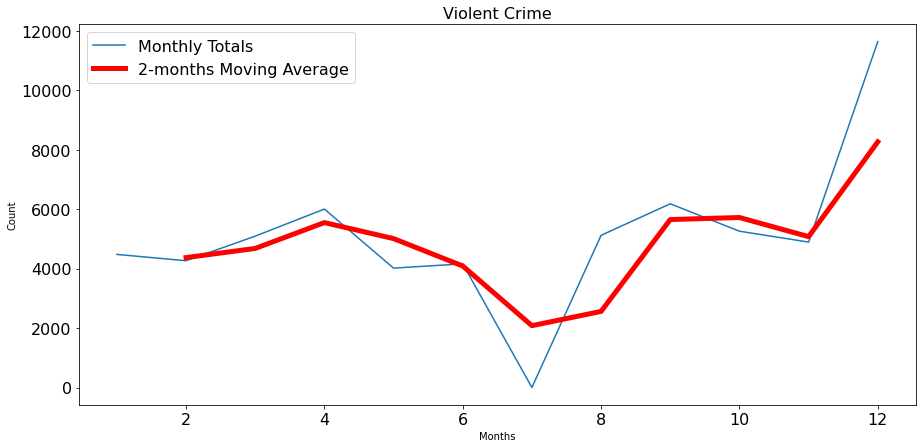

In [21]:
plt.figure(figsize = (15,7))
plt.plot(df_cr_violence_months['month'], df_cr_violence_months['violence'], label = 'Monthly Totals')
plt.plot(df_cr_violence_months['month'], df_cr_violence_months['violence'].rolling(window=2).mean(),
         color='red', linewidth=5, label='2-months Moving Average')
plt.title('Violent Crime', fontsize=16)
plt.xlabel('Months')
plt.ylabel('Count')
plt.legend(prop={'size':16})
plt.tick_params(labelsize=16);

The temporal range is July 2020 - July 2021

# Mapping burglaries

In [22]:
df_ct_burglary = df[df['Crime type'] == 'Burglary']
unique_locations_burglary = df_ct_burglary['unique_locations'].value_counts()

burglary_index = pd.DataFrame({"Raw strings" : unique_locations_burglary.index,
                               "Value count" : unique_locations_burglary})
burglary_index.index = range(len(unique_locations_burglary))
burglary_index.head()
temp_index_list_b = list(burglary_index['Raw strings'])

burglary_index['LocationCoord_long'], burglary_index['LocationCoord_lat'] = Location_extractor1(temp_index_list_b)
burglary_index = burglary_index.drop(columns=['Raw strings'], axis = 1)
burglary_index.head()

,Value count,LocationCoord_long,LocationCoord_lat
0,24,-2.973130,53.323908
1,15,-2.938149,53.396415
2,14,-2.977115,53.406242
3,13,-2.944864,53.395382
4,13,-2.963382,53.400295


In [23]:
liverpool_map_burglary = folium.Map(location=[53.400002, -2.983333],
                           zoom_start=13,
                           tiles="CartoDB dark_matter")
for i in range(500):
    lat = burglary_index['LocationCoord_lat'].iloc[i]
    long = burglary_index['LocationCoord_long'].iloc[i]
    radius = burglary_index['Value count'].iloc[i] / 1.25
    if burglary_index['Value count'].iloc[i] > 5:
        color = "#FF4500"
    else:
        color = "#008080"
        
    popup_text = """ Latitude: {}<br>
                Longitude: {}<br>
                Burglaries : {}<br>"""
    popup_text = popup_text.format(lat, long, burglary_index['Value count'].iloc[i])
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, 
                        color = color, fill = True).add_to(liverpool_map_burglary)

folium.TileLayer('cartodbpositron').add_to(liverpool_map_burglary)

#liverpool_map_burglary.save("mymap3.html")   
#webbrowser.open("mymap3.html") ## built-in py module opens map in browser
liverpool_map_burglary